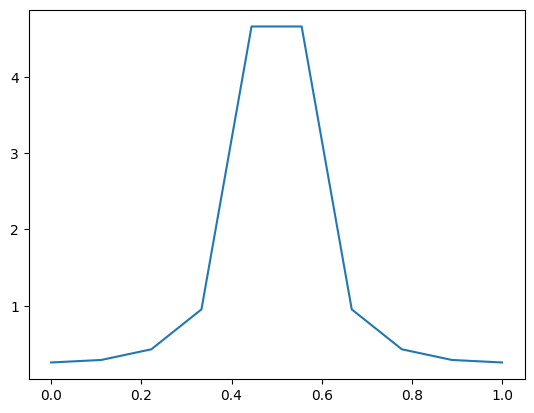

In [48]:
import src.diffusion as diffusionModule
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(diffusionModule)
x = np.linspace(0,1 ,10)
plt.plot(x , diffusionModule.oscillation(x))

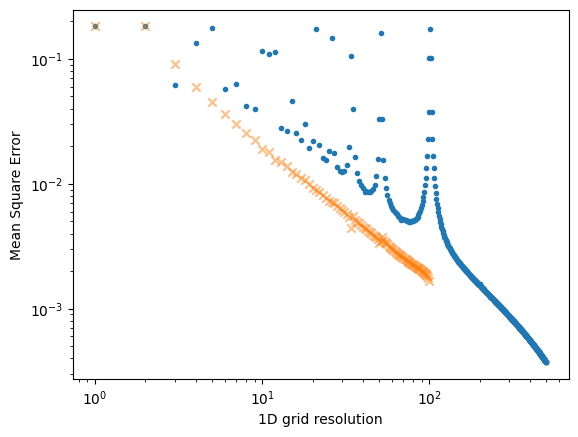

In [ ]:
import src.fvsolver as fvModule
diffusionFunction = lambda x: diffusionModule.oscillation(x,eps=0.01)


fineX = np.linspace(0, 1, 1000)
solver = fvModule.FVSolver(1000, diffusionFunction, (0,1))
solver.set_boundary()
solver.assemble_matrix()
referenceSolution = solver.solve()

# plt.plot(fineX , referenceSolution)

gridCoarseLevels = np.arange(1, 500, 1)
gridCoarseLevelsMulti = np.arange(1, 100, 1)

singleScaleErrorLevels = []
multiScaleErrorLevels = []

for corseLevel in gridCoarseLevels:
    # solve single scale
    coarseX = np.linspace(0,1 ,corseLevel)
    solver = fvModule.FVSolver(corseLevel, diffusionFunction, (0,1))
    solver.set_boundary()
    solver.assemble_matrix()
    coarseSolution = solver.solve()
    interpolatedCoarseSolution = np.interp(fineX, coarseX, coarseSolution)
    error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
    singleScaleErrorLevels.append(error)

for corseLevel in gridCoarseLevelsMulti:
    #solve multi scale
    coarseX = np.linspace(0,1 ,corseLevel)
    solver = fvModule.FVSolver(corseLevel, diffusionFunction, (0,1))
    solver.set_boundary()
    solver.set_multiscale_transmissions(1000)
    solver.assemble_matrix()
    coarseSolution = solver.solve()
    interpolatedCoarseSolution = np.interp(fineX, coarseX, coarseSolution)
    error = np.sqrt(np.mean(np.square(referenceSolution - interpolatedCoarseSolution)))
    multiScaleErrorLevels.append(error)




plt.scatter(gridCoarseLevels, singleScaleErrorLevels, marker=".")
plt.scatter(gridCoarseLevelsMulti, multiScaleErrorLevels, marker="x", alpha=0.5)

plt.xlabel("1D grid resolution")
plt.ylabel("Mean Square Error")
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

